In [3]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt

In [5]:
concepts = pd.read_json('../data/dictionary.json').T['label']

In [81]:
from datasets import load_dataset
""" ...We split EURLEX57K into training (45k documents), development (6k), and test subsets (6k) ..."""
train = load_dataset('eurlex', 'eurlex57k', split='train')
test = load_dataset('eurlex', 'eurlex57k', split='test')
val = load_dataset('eurlex', 'eurlex57k', split='validation')
len(train), len(test), len(val)

Reusing dataset eurlex (/Users/albina-volk/.cache/huggingface/datasets/eurlex/eurlex57k/1.1.0/d2fdeaa4fcb5f41394d2ed0317c8541d7f9be85d2d601b9fa586c8b461bc3a34)
Reusing dataset eurlex (/Users/albina-volk/.cache/huggingface/datasets/eurlex/eurlex57k/1.1.0/d2fdeaa4fcb5f41394d2ed0317c8541d7f9be85d2d601b9fa586c8b461bc3a34)
Reusing dataset eurlex (/Users/albina-volk/.cache/huggingface/datasets/eurlex/eurlex57k/1.1.0/d2fdeaa4fcb5f41394d2ed0317c8541d7f9be85d2d601b9fa586c8b461bc3a34)


(45000, 6000, 6000)

In [68]:
def ohe(dataset):
    one_hot = MultiLabelBinarizer()
    labels = dataset['eurovoc_concepts']
    ohe = pd.DataFrame(one_hot.fit_transform(labels).T, index=one_hot.classes_)
    ohe = pd.merge(concepts, ohe, left_index=True, right_index=True)
    ohe.index = ohe['label']
    ohe = ohe.drop('label', axis=1)
    ohe = ohe.T
    return ohe

In [78]:
ohe_train = ohe(train)
ohe_val = ohe(val)
ohe_test = ohe(test)
all_documents = pd.concat([ohe_train, ohe_val, ohe_test]).fillna(0)
ohe_train = all_documents[:45000]
ohe_val = all_documents[45000:51000]
ohe_test = all_documents[51000:]

In [80]:
""" ...in EURLEX57K, from which only 2,049 (47.97%) have been assigned to more than 10 documents... """
(all_documents.sum() >= 10).sum(), (all_documents.sum() >= 10).sum() / len(all_documents.columns)

(2049, 0.47974713181924605)

In [84]:
"""...We also divide the 4,271 labels into frequent (746), few-shot (3,362), and zero-shot (163), depending on whether they were
assigned to more than 50, fewer than 50 but at least one, or no training documents, respectively..."""
print(f"frequent: {(ohe_train.sum() >= 50).sum()}")
print(f"few-shot: {(ohe_train.sum() > 0).sum() - (ohe_train.sum() >= 50).sum()}")
print(f"zero-shot: {(ohe_train.sum() == 0).sum()}")

frequent: 746
few-shot: 3362
zero-shot: 163


<AxesSubplot:>

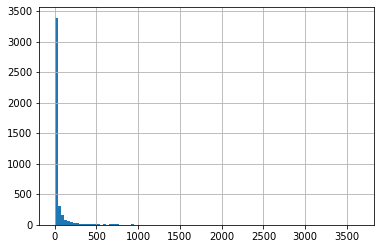

In [82]:
ohe_train.sum().hist(bins=100)